# Dynamic Window Approach

<a href="https://colab.research.google.com/github/LinkHS/Colab/blob/master/%20Self-driving/PathPlanning/dynamic_window_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- 论文：[The Dynamic Window Approach to Collision Avoidance](https://www.ri.cmu.edu/pub_files/pub1/fox_dieter_1997_1/fox_dieter_1997_1.pdf)
- 代码：[Python Robotics](https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/DynamicWindowApproach/dynamic_window_approach.py)

In [1]:
import math
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np

show_animation = True

车辆本身参数，包括形状（圆形、长方形）、最大/最小速度等：

In [3]:
class RobotType(Enum):
  circle = 0
  rectangle = 1

class Config:
  """
  simulation parameter class
  """
  def __init__(self):
    # robot parameter
    self.max_speed = 1.0  # [m/s]
    self.min_speed = -0.5  # [m/s]
    self.max_yaw_rate = 40.0 * math.pi / 180.0  # [rad/s]
    self.max_accel = 0.2  # [m/ss]
    self.max_delta_yaw_rate = 40.0 * math.pi / 180.0  # [rad/ss]
    self.v_resolution = 0.01  # [m/s]
    self.yaw_rate_resolution = 0.1 * math.pi / 180.0  # [rad/s]
    self.dt = 0.1  # [s] Time tick for motion prediction
    self.predict_time = 3.0  # [s]
    self.to_goal_cost_gain = 0.15
    self.speed_cost_gain = 1.0
    self.obstacle_cost_gain = 1.0
    self.robot_stuck_flag_cons = 0.001  # constant to prevent robot stucked
    self.robot_type = RobotType.circle

    # if robot_type == RobotType.circle
    # Also used to check if goal is reached in both types
    self.robot_radius = 1.0  # [m] for collision check

    # if robot_type == RobotType.rectangle
    self.robot_width = 0.5  # [m] for collision check
    self.robot_length = 1.2  # [m] for collision check
    # obstacles [x(m) y(m), ....]
    self.ob = np.array([[-1, -1],
                [0, 2],
                [4.0, 2.0],
                [5.0, 4.0],
                [5.0, 5.0],
                [5.0, 6.0],
                [5.0, 9.0],
                [8.0, 9.0],
                [7.0, 9.0],
                [8.0, 10.0],
                [9.0, 11.0],
                [12.0, 13.0],
                [12.0, 12.0],
                [15.0, 15.0],
                [13.0, 13.0]
               ])

  @property
  def robot_type(self):
    return self._robot_type

  @robot_type.setter
  def robot_type(self, value):
    if not isinstance(value, RobotType):
      raise TypeError("robot_type must be an instance of RobotType")
    self._robot_type = value


## 运动方程
状态$\mathbf{x}$：位置$x$（m）、位置$y$（m）、航向角$\theta$（rad）、速度$v$（m/s）、角速度$\omega$（rad/s）。

控制量$\mathbf{u}$：加速度、角速度。

这里假设车辆（近似）在$\Delta t$间隔内的速度与角速度是常数：

$$
x = x + v \Delta t\cos(\theta) \\
y = y + v \Delta t\sin(\theta) \\
\theta = \theta + \omega \Delta t
$$

In [4]:
def motion(x, u, dt):
  """
  motion model
  """
  x[2] += u[1] * dt # 航向角
  x[0] += u[0] * math.cos(x[2]) * dt # 位置x
  x[1] += u[0] * math.sin(x[2]) * dt # 位置y
  x[3] = u[0] # 加速度
  x[4] = u[1] # 角速度

  return x

## 轨迹预测


In [5]:
def predict_trajectory(x_init, v, y, config):
  """predict trajectory with an input
  @v, 加速度
  @y, 角速度
  """
  x = np.array(x_init)
  trajectory = np.array(x)
  time = 0
  while time <= config.predict_time:
    x = motion(x, [v, y], config.dt)
    trajectory = np.vstack((trajectory, x))
    time += config.dt

  return trajectory

### 运动轨迹模拟
假设车辆初始时刻所有状态为0，然后以$10m/s^2$的加速度和$30^\circ/s$的角速度行驶3秒钟：

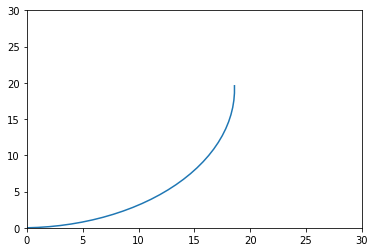

In [6]:
import matplotlib.pyplot as plt

x = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
u = np.array([10.0, np.deg2rad(30)])
config = Config()
# config.dt = 0.01 # Unit: second
config.predict_time = 3

x_hst = predict_trajectory(x, u[0], u[1], config)

plt.plot(x_hst[:, 0], x_hst[:, 1])
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.show()

## 动态窗口确定动作搜索空间

车辆本身运动参数$v, \omega$（速度，角速度）集合$V_s$：$[v_{max}, v_{min}, \omega_{max}, \omega_{min}]$

动态窗口运动参数集合$V_d$：$[v'_{max}, v'_{min}, \omega'_{max}, \omega'_{min}]$，其中$v'_{max} = v + a_{max} \Delta t$，$v'_{min} = v - a_{max} \Delta t$，角速度变化范围类似。公式如下：

$$
V_{d}=\left\{(v, \omega) \mid v \in \left[v_{a}-\dot{v} \cdot t, v_{a}+\dot{v} \cdot t\right],\quad \omega \in \left[\omega_{a}-\dot{\omega} \cdot t, \omega_{a}+\dot{\omega} \cdot t\right]\right\}
$$

算法搜索的动态空间为两者交集：

$$
V_{r}=V_{s} \cap V_{d}
$$

`calc_dynamic_window()`，当给定状态$x$时，根据所定义的机器人的最大加速度和最大转向加速度，给出一个缩小的动作空间`dw`，它是由机器人自身扭力矩大小所完全确定的，下一时刻所能到达的动作空间，大大提高了搜索速度。

> 该窗口仅包含下一个时间间隔内可以达到的速度，动态窗口外的所有轨迹都不能在下一个时间间隔内达到，因此可以不考虑避障。

In [7]:
def calc_dynamic_window(x, config):
  """
  calculation dynamic window based on current state x
  """
  # Dynamic window from robot specification
  Vs = [config.min_speed, config.max_speed,
      -config.max_yaw_rate, config.max_yaw_rate]

  # Dynamic window from motion model
  Vd = [x[3] - config.max_accel * config.dt,
      x[3] + config.max_accel * config.dt,
      x[4] - config.max_delta_yaw_rate * config.dt,
      x[4] + config.max_delta_yaw_rate * config.dt]

  #  [v_min, v_max, yaw_rate_min, yaw_rate_max]
  dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
      max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

  return dw

## 轨迹目标函数
目标函数包含三部分：

$$
\mathcal{L} = \alpha \mathcal{L}_{\text{obstacle}} + \beta \mathcal{L}_{\text{speed}} + \gamma \mathcal{L}_{\text{goal}} 
$$


### 距离代价

车辆行驶过程中距离障碍物越远越好：

$$
\mathcal{L}_\text{obstacle} = \left\{\begin{matrix}
\infty, & \quad \text{any}(r)<0 \\
1/\min(r), & \quad \text{other}
\end{matrix}\right.
$$

计算轨迹点和障碍物的距离：
> `a[:, None]`扩展第二维度为1。例如`a.shape=(3,2)`，那么`a[:, None].shape=(3,1,2)`

In [8]:
# 障碍物坐标，数量为3
ob = np.array([[-1, -1],
         [0, 2],
         [4.0, 2.0]])
ox = ob[:, 0] # shape: (3,)
oy = ob[:, 1] # shape: (3,)

# 历史轨迹，数量为5
config.predict_time = config.dt * (5-2)
trajectory = predict_trajectory(x, u[0], u[1], config)

# ox[:, None]扩展了ox的shape为(3, 1)
dx = trajectory[:, 0] - ox[:, None]
dy = trajectory[:, 1] - oy[:, None]

print(trajectory[:, 0].shape, ox[:, None].shape, dx.shape)

(5,) (3, 1) (3, 5)


结果显示`dx.shape=(3,5)`，表示3个障碍物分别和5个轨迹点的x距离。

**(a) 如果车辆是圆形**，直接计算hypotenuse（$r = \sqrt{dx^2 + dy^2}$）：

In [9]:
r = np.hypot(dx, dy)
r.shape

(3, 5)

根据公式计算距离代价：

In [10]:
if np.array(r <= config.robot_radius).any():
  Lo = float("Inf")
else:
  Lo = 1.0 / np.min(r)

print("Cost of obstacle is:", Lo)

Cost of obstacle is: 0.7071067811865475


**(b) 如果车辆是长方形**，需要考虑车辆方向，首先计算出每个轨迹点方向的旋转矩阵：

![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210813185146.png)

In [11]:
yaw = trajectory[:, 2]
# 构建旋转矩阵
rot = np.array([[np.cos(yaw), -np.sin(yaw)],
          [np.sin(yaw), np.cos(yaw)]])
# shape: (2, 2, n) => (n, 2, 2)
print("Before transpose, the shape is:", rot.shape)
rot = np.transpose(rot, [2, 0, 1])
print("After transpose, the shape is:", rot.shape)

Before transpose, the shape is: (2, 2, 5)
After transpose, the shape is: (5, 2, 2)


然后计算所有障碍物分别在每个轨迹点车辆坐标系下的距离，分为2步：
1. 计算障碍物在原点坐标系下和每个轨迹点的距离（不考虑旋转）$(dx, dy)$
2. 将$dx, dy$转换到每个轨迹点车辆坐标系下表示：$R \cdot [dx, dy]^T$

In [12]:
# 1. 计算障碍物在原点坐标系下和每个轨迹点的距离（不考虑旋转）
# shape: (5, 3, 2) = (5, 1, 2) - (3, 2)
local_ob = trajectory[:, None, 0:2] - ob
print(local_ob.shape)

# 2. 将障碍物距离转换到车辆坐标系下(3, 5, 2) @ (5, 2, 2)
local_ob = np.array([l @ x for l, x in zip(local_ob, rot)])
print(local_ob.shape)

(5, 3, 2)
(5, 3, 2)


结果`(5, 3, 2)`为3个障碍物分别在5个轨迹点坐标系下的表示。

最后在自己坐标系下直接和本车长宽比较就可以了。

这一节所有代码封装至`calc_obstacle_cost()`函数中：

In [13]:
def calc_obstacle_cost(trajectory, ob, config):
  """
  calc obstacle cost inf: collision
  """
  ox = ob[:, 0]
  oy = ob[:, 1]
  dx = trajectory[:, 0] - ox[:, None]
  dy = trajectory[:, 1] - oy[:, None]
  r = np.hypot(dx, dy)

  if config.robot_type == RobotType.rectangle:
    yaw = trajectory[:, 2]
    # 构建旋转矩阵
    rot = np.array([[np.cos(yaw), -np.sin(yaw)],
              [np.sin(yaw), np.cos(yaw)]])
    # shape: (2, 2, n) => (n, 2, 2)
    rot = np.transpose(rot, [2, 0, 1]) 
    
    local_ob = ob[:, None] - trajectory[:, 0:2]
    local_ob = local_ob.reshape(-1, local_ob.shape[-1])
    local_ob = np.array([local_ob @ x for x in rot])

    # 1. 计算障碍物在原点坐标系下和每个轨迹点的距离（不考虑旋转）
    # n_t: number of trajectory; n_o: number of obstacles
    # shape: (n_t, n_o, 2) = (n_t, 1, 2) - (n_o, 2)
    local_ob = trajectory[:, None, 0:2] - ob
    # 2. 将障碍物距离转换到车辆坐标系下，每次循环：(n_o, 2) X (2, 2)
    local_ob = np.array([l @ x for l, x in zip(local_ob, rot)])
    # shape (n_t, n_o, 2) => (n_t*n_o, 2)
    local_ob = local_ob.reshape(-1, local_ob.shape[-1])

    upper_check = local_ob[:, 0] <= config.robot_length / 2
    right_check = local_ob[:, 1] <= config.robot_width / 2
    bottom_check = local_ob[:, 0] >= -config.robot_length / 2
    left_check = local_ob[:, 1] >= -config.robot_width / 2
    if (np.logical_and(np.logical_and(upper_check, right_check),
               np.logical_and(bottom_check, left_check))).any():
      return float("Inf")
  elif config.robot_type == RobotType.circle:
    if np.array(r <= config.robot_radius).any():
        return float("Inf")

  min_r = np.min(r)
  return 1.0 / min_r  # OK

### 目标方向代价
![](https://images-picgo.oss-cn-shanghai.aliyuncs.com/images/Colab/20210813185623.png)

行进方向与目标方向的夹角越小越好。

$$
\mathcal{L}_\text{goal} = |\Delta \theta|
$$

需要注意的是$\Delta \theta$有可能超过180度，所以需要取180度的余数`abs(cost_angle) % np.pi`，也有代码中使用下面这种方式取余数：

$cost = \arctan2(\sin(\theta), \cos(\theta))$

In [14]:
def calc_to_goal_cost(trajectory, goal):
  """calc to goal cost with angle difference
  """
  dx = goal[0] - trajectory[-1, 0] # 取轨迹最后一个点
  dy = goal[1] - trajectory[-1, 1]
  goal_angle = math.atan2(dy, dx) # 目标角度
  cost_angle = goal_angle - trajectory[-1, 2] # 减去当前车辆航向角
  # OR：cost = abs(cost_angle) % np.pi
  cost = abs(math.atan2(math.sin(cost_angle), math.cos(cost_angle)))
  return cost

#### 模拟实验
假设目标点为(20, 20)，轨迹最后一个点为(10, 10)，航向角为45度，那么差值应该为0：

In [15]:
trajectory = np.array([[10, 10, np.deg2rad(45)]])
goal = np.array([20, 20])
calc_to_goal_cost(trajectory, goal)

0.0

### 速度代价
这一项最简单，也就是车辆速度越大越好：

$$
\mathcal{L}_\text{speed} = V_{max} - V
$$


In [16]:
trajectory = np.array([[10, 10, np.deg2rad(45), 0]]) # 第四项为速度

config.max_speed - trajectory[-1, 3]

1.0

## 遍历搜索
至此，当给定状态x、一个动态窗口dw、目标位置、障碍物位置时，只需要对动态窗口dw内的动作空间（速度$v$和角速度$\omega$）进行遍历，计算出每一个可能的动作在未来一段时间内所产生的轨迹，并在所有轨迹里找出一条评价最高的轨迹，返回最佳动作和最佳轨迹。

### 防止陷入局部最优
一般情况下车辆应该朝着目标方向前进，但是当前方有障碍物时并且车辆朝向指向目标，此时一种可能的局部最优解：速度为0、方向为0（即角速度为0），此时强制让车辆调整朝向，代码如下：
```python
if v < config.robot_stuck_flag_cons \
  omega < config.robot_stuck_flag_cons:
  omega = -config.max_delta_yaw_rate
```

In [17]:
def calc_control_and_trajectory(x, dw, config, goal, ob):
  """
  calculation final input with dynamic window
  """
  x_init = x[:]
  min_cost = float("inf")
  best_u = [0.0, 0.0]
  best_trajectory = np.array([x])

  # evaluate all trajectory with sampled input in dynamic window
  for v in np.arange(dw[0], dw[1], config.v_resolution):
    for y in np.arange(dw[2], dw[3], config.yaw_rate_resolution):
      trajectory = predict_trajectory(x_init, v, y, config)
      # calc cost
      to_goal_cost = config.to_goal_cost_gain * calc_to_goal_cost(trajectory, goal)
      speed_cost = config.speed_cost_gain * (config.max_speed - trajectory[-1, 3])
      ob_cost = config.obstacle_cost_gain * calc_obstacle_cost(trajectory, ob, config)

      final_cost = to_goal_cost + speed_cost + ob_cost

      # search minimum trajectory
      if min_cost >= final_cost:
        min_cost = final_cost
        best_u = [v, y]
        best_trajectory = trajectory
        if abs(best_u[0]) < config.robot_stuck_flag_cons \
          and abs(x[3]) < config.robot_stuck_flag_cons:
          # to ensure the robot do not get stuck in
          # best v=0 m/s (in front of an obstacle) and
          # best omega=0 rad/s (heading to the goal with
          # angle difference of 0)
          best_u[1] = -config.max_delta_yaw_rate
  return best_u, best_trajectory


## 初始化

初始化状态x：位置x（m）、位置y（m）、航向角yaw（rad）、速度v（m/s）、角速度w（rad/s）

目标位置goal：gx，gy

仿真参数config：最大/最小速度、拐弯半径、障碍物等

In [18]:
# initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
x = np.array([0.0, 0.0, math.pi / 8.0, 0.0, 0.0])
# goal position [x(m), y(m)]
goal = np.array([10.0, 10.0])

# input [forward speed, yaw_rate]
config.robot_type = RobotType.circle
trajectory = np.array(x)

config = Config()

障碍物位置：

In [19]:
ob = config.ob # obstacles [[x(m) y(m)], ....]
ob

array([[-1., -1.],
       [ 0.,  2.],
       [ 4.,  2.],
       [ 5.,  4.],
       [ 5.,  5.],
       [ 5.,  6.],
       [ 5.,  9.],
       [ 8.,  9.],
       [ 7.,  9.],
       [ 8., 10.],
       [ 9., 11.],
       [12., 13.],
       [12., 12.],
       [15., 15.],
       [13., 13.]])

## 模拟实验

In [20]:
def plot_arrow(x, y, yaw, length=0.5, width=0.1):  # pragma: no cover
  plt.arrow(x, y, length*math.cos(yaw), length*math.sin(yaw),
       head_length=width, head_width=width)
  plt.plot(x, y)


def plot_robot(x, y, yaw, config):  # pragma: no cover
  if config.robot_type == RobotType.rectangle:
    outline = np.array([[-config.robot_length / 2, config.robot_length / 2,
                (config.robot_length / 2), -config.robot_length / 2,
                -config.robot_length / 2],
                [config.robot_width / 2, config.robot_width / 2,
                - config.robot_width / 2, -config.robot_width / 2,
                config.robot_width / 2]])
    Rot1 = np.array([[math.cos(yaw), math.sin(yaw)],
              [-math.sin(yaw), math.cos(yaw)]])
    outline = (outline.T.dot(Rot1)).T
    outline[0, :] += x
    outline[1, :] += y
    plt.plot(np.array(outline[0, :]).flatten(),
         np.array(outline[1, :]).flatten(), "-k")
  elif config.robot_type == RobotType.circle:
    circle = plt.Circle((x, y), config.robot_radius, color="b")
    plt.gcf().gca().add_artist(circle)
    out_x, out_y = (np.array([x, y]) +
              np.array([np.cos(yaw), np.sin(yaw)]) * config.robot_radius)
    plt.plot([x, out_x], [y, out_y], "-k")


In [21]:
from IPython import display

def main(gx=10.0, gy=10.0, robot_type=RobotType.circle):
  # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
  x = np.array([0.0, 0.0, math.pi / 8.0, 0.0, 0.0])
  # goal position [x(m), y(m)]
  goal = np.array([gx, gy])

  # input [forward speed, yaw_rate]

  config.robot_type = robot_type
  trajectory = np.array(x)
  ob = config.ob

  fig = plt.figure()
  plt.axis("equal")
  plt.grid(True)
  while True:
    dw = calc_dynamic_window(x, config)
    u, predicted_trajectory = calc_control_and_trajectory(x, dw, config, goal, ob)
    x = motion(x, u, config.dt)  # simulate robot
    trajectory = np.vstack((trajectory, x))  # store state history

    if show_animation:
      plt.cla()
      plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], "-g")
      plt.plot(x[0], x[1], "xr")
      plt.plot(goal[0], goal[1], "xb")
      plt.plot(ob[:, 0], ob[:, 1], "ok")
      plot_robot(x[0], x[1], x[2], config)
      plot_arrow(x[0], x[1], x[2])
      display.display(fig)
      display.clear_output(wait=True)

    # check reaching goal
    dist_to_goal = math.hypot(x[0] - goal[0], x[1] - goal[1])
    if dist_to_goal <= config.robot_radius:
      print("Goal!!")
      break

  print("Done")
  if show_animation:
    plt.plot(trajectory[:, 0], trajectory[:, 1], "-r")
    display.display(fig)
    display.clear_output(wait=True)

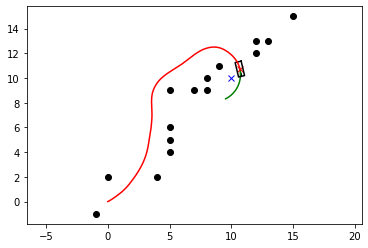

In [22]:
main(robot_type=RobotType.rectangle)

---
## 附录：Numpy中的Broadcast
Numpy中，当运算符两边变量的shape不满足运算符要求时，在满足一些规则下，Numpy会启动Broadcast，例如下面$a-b$：

In [23]:
import numpy as np

a = np.zeros((3,3))
b = np.array([1])
print(a-b, '\n\n', b-a, '\n')
a.shape, b.shape, (a-b).shape, (b-a).shape

[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]] 

 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]] 



((3, 3), (1,), (3, 3), (3, 3))

当$a, b$的shape一样时，$a-b$为element-wise。

当$a,b$维度不相等时候，例如`a1 = a[:, None]`维度从$3\times3$变为了$3\times 1 \times 3$，那么$a1-b$就用到了Broadcast性质，即$a1$的第一行（其shape为$1 \times 3$）分别减$b$的每一行（每个shape都为$1 \times 3$），然后$a1$的第二行、第三行......

In [24]:
a = np.eye(3, 3)
b = np.arange(9).reshape(3, 3)
a1 = a[:, None]

print(a1.shape, b.shape, (a1-b).shape, '\n')
a1-b

(3, 1, 3) (3, 3) (3, 3, 3) 



array([[[ 1., -1., -2.],
        [-2., -4., -5.],
        [-5., -7., -8.]],

       [[ 0.,  0., -2.],
        [-3., -3., -5.],
        [-6., -6., -8.]],

       [[ 0., -1., -1.],
        [-3., -4., -4.],
        [-6., -7., -7.]]])

所以$a1, b$第一维也不需要相等（这里分别是5和3），只需要保证相减的维度是一样的，这里是$(1\times 3) - 3\times (1 \times 3)$：

In [25]:
a = np.eye(5, 3)
b = np.arange(9).reshape(3, 3)
a1 = a[:, None]

print(a1.shape, b.shape, (a1-b).shape, '\n')
a1-b

(5, 1, 3) (3, 3) (5, 3, 3) 



array([[[ 1., -1., -2.],
        [-2., -4., -5.],
        [-5., -7., -8.]],

       [[ 0.,  0., -2.],
        [-3., -3., -5.],
        [-6., -6., -8.]],

       [[ 0., -1., -1.],
        [-3., -4., -4.],
        [-6., -7., -7.]],

       [[ 0., -1., -2.],
        [-3., -4., -5.],
        [-6., -7., -8.]],

       [[ 0., -1., -2.],
        [-3., -4., -5.],
        [-6., -7., -8.]]])

同理$b-a1$和$a1-b$的结果只差个正负号：

In [26]:
a = np.eye(5, 3)
b = np.arange(9).reshape(3, 3)
a1 = a[:, None]

print(a1.shape, b.shape, (b-a1).shape, '\n')
(b-a1)

(5, 1, 3) (3, 3) (5, 3, 3) 



array([[[-1.,  1.,  2.],
        [ 2.,  4.,  5.],
        [ 5.,  7.,  8.]],

       [[ 0.,  0.,  2.],
        [ 3.,  3.,  5.],
        [ 6.,  6.,  8.]],

       [[ 0.,  1.,  1.],
        [ 3.,  4.,  4.],
        [ 6.,  7.,  7.]],

       [[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.]],

       [[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.]]])